### This is the second file please get the wildfire_aquistion if repoducing

## Step 1 Part 2:
Another problem is trying to understand how good or bad your smoke estimate might be. Once you have developed your smoke estimate, you should compare your estimate to available AQI (Air Quality Index) data from the US EPA. I hear you asking, "Why we don't simply use AQI as the estimate?" That's a reasonable question. First, the US EPA was only created in 1973, and did not really begin installing air quality monitoring stations until the early 1980s. Further, of 3000+ counties in the US, the EPA has vetted monitoring stations in only 2000 of them. This means that US EPA AQI measures for any one city will need to be some kind of estimate based on monitoring stations that are nearby. There are a few additional considerations that I have glossed over.

I have provided sample code for accessing the US EPA Air Quality System API. You will need to request an API key to access the API. You should test access to the API to understand whether you can get data for your city based on the US County where your city is located, or whether you need to create a geodetic bounding box to access station data. In either case, it is highly unlikely that your city has an AQS monitoring station directly in the city bounds - although it is possible.

When comparing your smoke estimate to the estimate you create from the EPA AQS, you should consider the nature of AQI measures, what they represent, how they are computed, and how they might be (or not be) related to fire smoke.

### first import essental modules and consants to be defined 

In [19]:
#    These are standard python modules

#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests.
#
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



## Example 1. Making a sign-up request

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.

In [5]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
# def request_signup(email_address = 'nizanh@uw.edu',
#                    endpoint_url = API_REQUEST_URL, 
#                    endpoint_action = API_ACTION_SIGNUP, 
#                    request_template = AQS_REQUEST_TEMPLATE,
#                    headers = None):

#     # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
#     if email_address:
#         request_template['email'] = email_address        
#     if not request_template['email']: 
#         raise Exception("Must supply an email address to call 'request_signup()'")

#     # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
#     request_url = endpoint_url+endpoint_action.format(**request_template)

#     # make the request
#     try:
#         # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
#         # during the request processing - throttling is always a good practice with a free data source
#         if API_THROTTLE_WAIT > 0.0:
#             time.sleep(API_THROTTLE_WAIT)
#         response = requests.get(request_url, headers=headers)
#         json_response = response.json()
#     except Exception as e:
#         print(e)
#         json_response = None
#     return json_response

# request_signup(email_address = 'nizanh@uw.edu')

{'Header': [{'status': 'Success',
   'request_time': '2023-11-08T04:46:15-05:00',
   'url': 'https://aqs.epa.gov/data/api/signup?email=nizanh@uw.edu'}],
 'Data': ['You should receive a registration confirmation email with a link for confirming your email shortly.']}

In [5]:
#   Once we have the signup email, we can define two constants
#   USERNAME - This should be the email address you sent the EPA asking for access to the API during sign-up
#   APIKEY   - This should be the authorization key they sent you
#
#   You can specify these as constants for your own use - just don't distribute the notebook without removing the constants
#
USERNAME = "nizanh@uw.edu"
APIKEY = "mauveheron58"

#### instructor function instruction:
## Example 2. Making a list request
Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page.

In [6]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [8]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

We're interested in getting to something that might be the Air Quality Index (AQI). You see this reported on the news - often around smog values, but also when there is smoke in the sky. The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...).

In [7]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


## instructor instructions 
We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor.

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

This list includes the FIPS number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.

### not specficed fifs for site and place my insance of city 

In [8]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

#   Used my specific city below:
#
CITY_LOCATIONS = {
    "Coeur d’Alene" :       {'city'   : "Coeur d’Alene",
                       'county' : 'Kootenai County',
                       'state'  : 'Idaho',
                       'fips'   : '16055',
                       'latlon' : [47.702465, - 116.796883] }}


## method chosen

Given our CITY_LOCATIONS constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county. 

In [9]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS["Coeur d’Alene"]['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS["Coeur d’Alene"]['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": "Coeur d'Alene - Lancaster Rd."
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": "OPEN AREA, SOME ROLLING HILLS.  TRAFFIC FLOW IS A ROUGH ESTIMATE."
    },
    {
        "code": "0012",
        "value_represented": "SITE NEAR GRAVEL ROAD AND SURROUNDED BY AG. FIELDS (GRASS AND WHEAT

# Example 3. Making a daily summary request

The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.


In [10]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

## instructor instruction and difference 

### Example 3. Making a daily summary request

The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges

### personally used range from 1963 to 2023 if allowed to get a full data list of aqi in particulates for my city 

In [144]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] =  AQI_PARAMS_PARTICULATES
request_data['state'] = CITY_LOCATIONS["Coeur d’Alene"]['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS["Coeur d’Alene"]['fips'][2:]  # the last three digits (characters) of FIPS is the county code

# # request daily summary data from 1963 to 2023
# gaseous_aqi = request_daily_summary(request_template=request_data, begin_date="20230101", end_date="20231231")
# print("Response for the gaseous pollutants ...")
# #
# if gaseous_aqi["Header"][0]['status'] == "Success":
#     print(json.dumps(gaseous_aqi['Data'],indent=4))
# elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
#     print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
# else:
#     print(json.dumps(gaseous_aqi,indent=4))

request_data['param'] = AQI_PARAMS_PARTICULATES

# Looping through the particales for the year 1963 to 2023
date_strings1 = [f"{year}0101" for year in range(1963, 2023 + 1)] # Got the start and end date params
date_strings2 = [f"{year}1231" for year in range(1963, 2023 + 1)]

df_result = pd.DataFrame()
aqi_par_date = []
aqi_par_rating =[]
particulate_aqi_df = pd.DataFrame(columns = ["Date","AQI_rati"]) # dataframe to store it in 

for date1, date2 in zip(date_strings1, date_strings2):
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=date1, end_date=date2)
    if 'Data' in particulate_aqi and particulate_aqi['Data']:
        for data in particulate_aqi['Data']:
            aqi_par_date.append(data['date_local']) #getting the specific frames 
            aqi_par_rating.append(data['aqi'])
    else:
        print(f"{date1} year does not have any particulate aqi") # showcasing how many blanks the data has
        year = date1[:-4]
        aqi_par_date.append(year)
        aqi_par_rating.append(0)




19630101 year does not have any particulate aqi
19640101 year does not have any particulate aqi
19650101 year does not have any particulate aqi
19660101 year does not have any particulate aqi
19670101 year does not have any particulate aqi
19680101 year does not have any particulate aqi
19690101 year does not have any particulate aqi
19700101 year does not have any particulate aqi
19710101 year does not have any particulate aqi
19720101 year does not have any particulate aqi
19730101 year does not have any particulate aqi
19740101 year does not have any particulate aqi
19750101 year does not have any particulate aqi
19760101 year does not have any particulate aqi
19770101 year does not have any particulate aqi
19780101 year does not have any particulate aqi
19790101 year does not have any particulate aqi
19800101 year does not have any particulate aqi
19810101 year does not have any particulate aqi
19820101 year does not have any particulate aqi
19830101 year does not have any particul

# Saving to a df and checking the data set frame 

I noticed the dataset had issues of duppliation of api and dates 
will correct int the cleaning state, but first saving to csv 

In [146]:
# frame work to save in a csv: 
particulate_aqi_df = pd.DataFrame(list(zip(aqi_par_date, aqi_par_rating )),
               columns =['year_month', 'aqi'])
                            

In [147]:
particulate_aqi_df # checking the subset

,year_month,aqi
0,1963,0.0
1,1964,0.0
2,1965,0.0
3,1966,0.0
4,1967,0.0
...,...,...
27417,2023-06-28,22.0
27418,2023-06-29,NaN
27419,2023-06-29,24.0
27420,2023-06-30,NaN


In [148]:
particulate_aqi_df.to_csv('particulate_aqi.csv') # save to csv file large runtime and more efficent 

### Repetition for Gaseous Parameter

I re-ran my creaded instance and changed the values set from particulate aqi to gaseous 

In [12]:
request_data['param'] = AQI_PARAMS_GASEOUS

# Looping through the particales for the year 1963 to 2023
date_strings1 = [f"{year}0101" for year in range(1963, 2023 + 1)]
date_strings2 = [f"{year}1231" for year in range(1963, 2023 + 1)]

df_result = pd.DataFrame()
gas_date = []
gas_rating =[]
gas_df = pd.DataFrame(columns = ["Date","AQI_rati"]) # dataframe to store it in 

for date1, date2 in zip(date_strings1, date_strings2):
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=date1, end_date=date2)
    if 'Data' in gaseous_aqi and gaseous_aqi['Data']:
        for data in gaseous_aqi['Data']:
            gas_date.append(data['date_local'])
            gas_rating.append(data['aqi'])
    else:
        print(f"{date1} year does not have any gaseous aqi")
        year = date1[:-4]
        gas_date.append(year)
        gas_rating.append(0)


19630101 year does not have any gaseous aqi
19640101 year does not have any gaseous aqi
19650101 year does not have any gaseous aqi
19660101 year does not have any gaseous aqi
19670101 year does not have any gaseous aqi
19680101 year does not have any gaseous aqi
19690101 year does not have any gaseous aqi
19700101 year does not have any gaseous aqi
19710101 year does not have any gaseous aqi
19720101 year does not have any gaseous aqi
19730101 year does not have any gaseous aqi
19740101 year does not have any gaseous aqi
19750101 year does not have any gaseous aqi
19760101 year does not have any gaseous aqi
19770101 year does not have any gaseous aqi
19780101 year does not have any gaseous aqi
19790101 year does not have any gaseous aqi
19800101 year does not have any gaseous aqi
19810101 year does not have any gaseous aqi
19820101 year does not have any gaseous aqi
19830101 year does not have any gaseous aqi
19840101 year does not have any gaseous aqi
19850101 year does not have any 

### Notice that there is very little data from the gaseous subset found 
I checked further by storing it into a data frame:

In [13]:
gaseous_aqi_df = pd.DataFrame(list(zip(gas_date, gas_rating )),
               columns =['year_month', 'aqi']) #storing to df


In [20]:
gaseous_aqi_df # printed result 

,year_month,aqi
0,1963,0.0
1,1964,0.0
2,1965,0.0
3,1966,0.0
4,1967,0.0
...,...,...
7401,2019,0.0
7402,2020,0.0
7403,2021,0.0
7404,2022,0.0


###  I could not find the gastreous aqi trying another approach alot of it was missing so I attempted the next provided instructions from the instructor : 

###### Example 4. Making request by bounding box
The AQS API has a mechanism of requesting data and monitoring stations using a geographic bounding box. The above examples just demonstrated the use of the AQS API for making requests by counties. The examples below illustrate the use of bounding boxes. The example below makes requests to identify monitoring stations within the bounding box. Once you knew you have monitoring stations, then the bounding box could be used in the daily summary requests to get AQS data.


In [20]:
#
#   These are rough estimates for creating bounding boxes based on a city location
#   You can find these rough estimates on the USGS website:
#   https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps
#
LAT_25MILES = 25.0 * (1.0/69.0)    # This is about 25 miles of latitude in decimal degrees
LON_25MILES = 25.0 * (1.0/54.6)    # This is about 25 miles of longitude in decimal degrees
#
#   Compute a rough estimates for a bounding box around a given place
#   The bounding box is scaled in 50 mile increments. That is the bounding box will have sides that
#   are rough multiples of 50 miles, with the center of the box around the indicated place.
#   The scale parameter determines the scale (size) of the bounding box
#
def bounding_latlon(place=None,scale=1.0):
    minlat = place['latlon'][0] - float(scale) * LAT_25MILES
    maxlat = place['latlon'][0] + float(scale) * LAT_25MILES
    minlon = place['latlon'][1] - float(scale) * LON_25MILES
    maxlon = place['latlon'][1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]

## This is the instance of re-runing previous code to get more gasteous aqi data 

In [21]:
#    This implements the monitors request. This requests monitoring stations. This can be done by state, county, or bounding box. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_monitors(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_MONITORS_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers
    
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
    
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

## Instructors instruction on how to run this 
Given the response above for Bend, OR - it looks like there are 5 monitoring sites that are in Deschutes County - AND that monitor particulate air quality. Their unique site IDs are given in the 'site_number' field of the dictionary. The response also includes their lat,lon positions should we need that. Comparing the site numbers to the response from the list request above - all of the sites here are there. So, things seem to be heading in the right direction.

### Based on my result I found there data was lacking the fifty mile estimate was out of the bounds of my city notice the data location ranged into spokane therefore I used on the particulate aqi. I also noticed that many people that I asked in class had this happen where gaseous recored is more faulty. 

In [27]:
#
#    Create a copy of the AQS_REQUEST_TEMPLATE
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS    # same particulate request as the one abover
# 
#   Not going to use these - comment them out
#request_data['state'] = CITY_LOCATIONS['bend']['fips'][:2]
#request_data['county'] = CITY_LOCATIONS['bend']['fips'][2:]
#
#   Now, we need bounding box parameters

#   50 mile box
#bbox = bounding_latlon(CITY_LOCATIONS["Coeur d’Alene"],scale=1.0)
#   100 mile box
bbox = bounding_latlon(CITY_LOCATIONS["Coeur d’Alene"],scale=2.0)
#   150 mile box
#bbox = bounding_latlon(CITY_LOCATIONS["Coeur d’Alene"],scale=3.0)
#   200 mile box
#bbox = bounding_latlon(CITY_LOCATIONS["Coeur d’Alene"],scale=4.0)

# the bbox response comes back as a list - [minlat,maxlat,minlon,maxlon]

#   put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]

#
#   we need to change the action for the API from the default to the bounding box - same recent date for now
response = request_monitors(request_template=request_data, begin_date="20210701", end_date="20210731",
                            endpoint_action = API_ACTION_MONITORS_BOX)
#
#
#
if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "state_code": "53",
        "county_code": "063",
        "site_number": "0046",
        "parameter_code": "44201",
        "poc": 1,
        "parameter_name": "Ozone",
        "open_date": "1990-04-01",
        "close_date": null,
        "concurred_exclusions": null,
        "dominant_source": null,
        "measurement_scale": "URBAN SCALE",
        "measurement_scale_def": "4 KM TO 50 KM",
        "monitoring_objective": "POPULATION EXPOSURE",
        "last_method_code": "087",
        "last_method_description": "INSTRUMENTAL - ULTRA VIOLET ABSORPTION",
        "last_method_begin_date": "2008-01-01",
        "naaqs_primary_monitor": "Y",
        "qa_primary_monitor": null,
        "monitor_type": "SLAMS",
        "networks": null,
        "monitoring_agency_code": "1136",
        "monitoring_agency": "Washington State Department Of Ecology",
        "si_id": 16764,
        "latitude": 47.82728,
        "longitude": -117.27422,
        "datum": "WGS84",
        "lat_

 ## Instructor instruction: 

When comparing your smoke estimate to the estimate you create from the EPA AQS, you should consider the nature of AQI measures, what they represent, how they are computed, and how they might be (or not be) related to fire smoke. 
comparison of the data frame.

### Note that im calling both the particulate_aqi data to clean then im reading the my smoke estimate for a notable comaparsion on whether the data is a good estimate of not. 
 
 

In [63]:
aqi_df = pd.read_csv('particulate_aqi.csv')
smoke_df = pd.read_csv('coeur_smoke_estimate_df.csv')

## AQI_ pre-proces 
- remove the nan and repeats each row has nan and aqi eg: [20201010: aqi:[nan,23]

- next seperate the month and year columns in the name to calluclate the average aqi per yea for the data set
- this is on the daily level so were changing it to the yearly level 

In [22]:
aqi_df

,Unnamed: 0,year_month,aqi
0,0,1963,0.0
1,1,1964,0.0
2,2,1965,0.0
3,3,1966,0.0
4,4,1967,0.0
...,...,...,...
27417,27417,2023-06-28,22.0
27418,27418,2023-06-29,NaN
27419,27419,2023-06-29,24.0
27420,27420,2023-06-30,NaN


In [24]:
aqi_df = aqi_df.dropna(subset=['aqi']) # drop for the duplicates 
aqi_df 

,Unnamed: 0,year_month,aqi
0,0,1963,0.0
1,1,1964,0.0
2,2,1965,0.0
3,3,1966,0.0
4,4,1967,0.0
...,...,...,...
27413,27413,2023-06-26,21.0
27415,27415,2023-06-27,22.0
27417,27417,2023-06-28,22.0
27419,27419,2023-06-29,24.0


In [34]:
# now to calcuate on the year level aqi split the year month column on the day into three components:
aqi_df ['year'] = aqi_df ['year_month'].str.extract(r'(\d{4})').astype(int)
#aqi_df ['month'] = aqi_df ['year_month'].str.extract(r'-(\d{2})').fillna('01').astype(int)
#aqi_df ['day'] = aqi_df ['year_month'].str.extract(r'-(\d{2})-(\d{2})').fillna('01').astype(int)


### Great now i will get the aqi thats on a daily sum by using the sum on group by year 
this will to  caculate the sum of the daily aqi values for each year to compare to my smoke estimates
however i need ot fill the empty aqi dail summ with an average of what i do have since i have over 25 rows of 

In [33]:
aqi_df # example

,Unnamed: 0,year_month,aqi,year,month
0,0,1963,0.0,1963,1
1,1,1964,0.0,1964,1
2,2,1965,0.0,1965,1
3,3,1966,0.0,1966,1
4,4,1967,0.0,1967,1
...,...,...,...,...,...
27413,27413,2023-06-26,21.0,2023,6
27415,27415,2023-06-27,22.0,2023,6
27417,27417,2023-06-28,22.0,2023,6
27419,27419,2023-06-29,24.0,2023,6


In [47]:
# Extract 'day' if the date is in "year-month-day" format
month_day = aqi_df['year_month'].str.extract(r'-(\d{2})-(\d{2})')# this will split year month to month day level
month_day.columns
#cleaner_aqi_df = pd.concat([aqi_df, month_day], axis=0)

Index([0, 1], dtype='int64')

In [53]:
aqi_df['month_fixed'] = month_day[0]
aqi_df['day'] = month_day[1]
clean_aqi_df = aqi_df[['aqi', 'year', 'month_fixed','day' ]]
clean_aqi_df 

,aqi,year,month_fixed,day
0,0.0,1963,NaN,NaN
1,0.0,1964,NaN,NaN
2,0.0,1965,NaN,NaN
3,0.0,1966,NaN,NaN
4,0.0,1967,NaN,NaN
...,...,...,...,...
27413,21.0,2023,06,26
27415,22.0,2023,06,27
27417,22.0,2023,06,28
27419,24.0,2023,06,29


### The annual AQI estimates average  megred df
Are now going to be mereged togtehr to get the comparisons on the different data, but it technicall needs a join because they only share  year column but theres missing years from both sides so an inner join is inplace to capture the whole data set only years that considered both sides of data 


In [61]:
annual_aqi_estimates_df = clean_aqi_df.groupby('year')['aqi'].mean().reset_index() # anual average estimates now
annual_aqi_estimates_df 


,year,aqi
0,1963,0.000000
1,1964,0.000000
2,1965,0.000000
3,1966,0.000000
4,1967,0.000000
...,...,...
56,2019,27.070423
57,2020,27.440678
58,2021,27.507830
59,2022,27.612813


### computed the average api from my data pool since over 25 years were missing from the daily request

In [72]:
# Calculating the average of non-zero 'aqi' values in the DataFrame
average_aqi = annual_aqi_estimates_df[annual_aqi_estimates_df['aqi'] != 0.0]['aqi'].mean()

# Fill the 'aqi' values of 0.0 with the calculated average
annual_aqi_estimates_df.loc[annual_aqi_estimates_df['aqi'] == 0.0, 'aqi'] = average_aqi

In [73]:
aqi_smoke_est_df = smoke_df.merge(annual_aqi_estimates_df, left_on='Fire_Year', right_on='year', how='inner')
aqi_smoke_est_df #merge on year 

,Unnamed: 0,Fire_Year,GIS_Acres,Shortest_distance,Shortest_distance.1,Smoke_estimate,year,aqi
0,0,1963,693.949136,609.691014,609.691014,4.027126e+09,1963,29.193636
1,1,1964,1228.901417,623.936665,623.936665,8.882221e+08,1964,29.193636
2,2,1965,753.312532,588.930012,588.930012,4.971877e+10,1965,29.193636
3,3,1966,1703.514155,610.720318,610.720318,5.058083e+09,1966,29.193636
4,4,1967,1138.451539,638.121377,638.121377,4.465429e+10,1967,29.193636
5,5,1968,831.313474,637.770158,637.770158,2.289966e+09,1968,29.193636
6,6,1969,638.751724,646.730026,646.730026,4.855948e+08,1969,29.193636
7,7,1970,1809.993841,612.488701,612.488701,9.100050e+09,1970,29.193636
8,8,1971,1598.764214,650.979360,650.979360,7.927055e+09,1971,29.193636
9,9,1972,838.668223,616.324927,616.324927,7.573907e+08,1972,29.193636


# My comparsion :
based of this data as you can see the reuslts show that over 25 years did not have any data to pull in particulate api which means that the data need there is an average of 29 across have the averages across which will skew but its okay my estimates a factured down a bit smaller because of the distance and area were larger but the does seem to be a larger but the scale does have features of insterest noted 

## Step 1.3
### Lastly, you should develop a predictive model based on the fire data and smoke estimate for your assigned city. Your model should predict smoke estimates for every year for the next 25 years (i.e., 2024-2049). You should be careful to make sure your predictions convey appropriate levels of uncertainty in the prediction.

## Using a Linear regression model I tried to predict the next 25 years of annual AQI estimates 

First taking my smoke estimates I use a linear regression model to predict the next 
25 years of the annual AQI though based on these estimates there hard to pinpoint 
if there is even a relationship 

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

data = aqi_smoke_est_df

# Split the data into features (X) and target (y)
# Split the data into training and testing sets
X = data[['Fire_Year', 'GIS_Acres', 'Shortest_distance', 'year']]
y = data['Smoke_estimate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Trains the Linear Regression model
# future years (2024-2049)
model = LinearRegression()
model.fit(X_train, y_train)
next25_years = np.arange(2024, 2050).reshape(-1, 1)  # 25 range of years
pred_data = pd.DataFrame({'Fire_Year': next25_years.flatten()})
existing_years = data['Fire_Year'].unique()


# Handle missing values with a placeholder value (0) since years end in 2022
# Extract the relevant feature values from your dataset for the future years
missing_years = set(range(2024, 2050)).difference(existing_years)
if missing_years:
    pred_data['GIS_Acres'] = 0
    pred_data['Shortest_distance'] = 0
    pred_data['year'] = 0
else:
    pred_data['GIS_Acres'] = data.loc[data['Fire_Year'].isin(range(2024, 2050)), 'GIS_Acres'].values
    pred_data['Shortest_distance'] = data.loc[data['Fire_Year'].isin(range(2024, 2050)), 'Shortest_distance'].values
    pred_data['year'] = data.loc[data['Fire_Year'].isin(range(2024, 2050)), 'year'].value
    
    
# Makes and prints the  predictions for the future years
predit_model = model.predict(pred_data)
for year, prediction in zip(next25_years.flatten(), predit_model):
    print(f'Year {year}: Predicted Smoke Estimate = {prediction}')

    
# Evaluate the model on the testing set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on Test Data: {mse}')
print(f'R-squared on Test Data: {r2}')

Year 2024: Predicted Smoke Estimate = -125781217337.0339
Year 2025: Predicted Smoke Estimate = -125731099910.0821
Year 2026: Predicted Smoke Estimate = -125680982483.13031
Year 2027: Predicted Smoke Estimate = -125630865056.17851
Year 2028: Predicted Smoke Estimate = -125580747629.22672
Year 2029: Predicted Smoke Estimate = -125530630202.27493
Year 2030: Predicted Smoke Estimate = -125480512775.32314
Year 2031: Predicted Smoke Estimate = -125430395348.37134
Year 2032: Predicted Smoke Estimate = -125380277921.41954
Year 2033: Predicted Smoke Estimate = -125330160494.46774
Year 2034: Predicted Smoke Estimate = -125280043067.51595
Year 2035: Predicted Smoke Estimate = -125229925640.56416
Year 2036: Predicted Smoke Estimate = -125179808213.61237
Year 2037: Predicted Smoke Estimate = -125129690786.66057
Year 2038: Predicted Smoke Estimate = -125079573359.70877
Year 2039: Predicted Smoke Estimate = -125029455932.75697
Year 2040: Predicted Smoke Estimate = -124979338505.80519
Year 2041: Predi

## Based on my estimate seems to have negative prediction  though the Rsquared test show that this a preliminary result and it should be greatly fixed adjusted based on my estimate changes and re-drafted for part2

### Step 2: Visualize aspects of your analysis
You will illustrate the work of your analysis with a few time series graphs. 
The wildfire data is annual, so your time series will be on an annual basis. All the time series should cover the analysis range defined above, but not the prediction range.

- Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.
- Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
- Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

In this last step I saw on slack questions answering the fig and then used the geeks for geeks matplot lib  for the last steps utlize https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/?ref=ml_lbp
that goes through the differen set up you wan to group by years to get acres, smoke estimates, and aqi estimates 
then plt using matplotlib and finally saving in a png

In [94]:
# Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

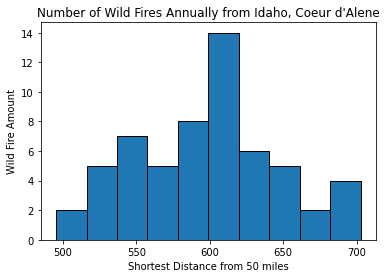

In [117]:
max_distance = aqi_smoke_est_df['Shortest_distance'].max() # get highest value 
plt.hist(aqi_smoke_est_df['Shortest_distance'], edgecolor='black')
plt.ylabel('Wild Fire Amount')
plt.xlabel('Shortest Distance from 50 miles')
plt.title("Number of Wild Fires Annually from Idaho, Coeur d'Alene")
plt.savefig("Wild Fires Annually from Idaho, Coeur d'Alene.png") 
plt.show()

In [95]:
#Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

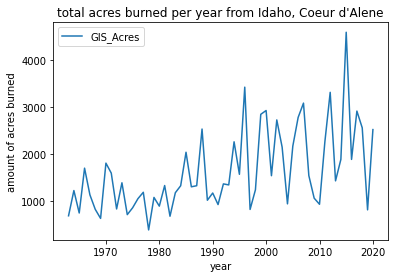

In [118]:
gis_acres = aqi_smoke_est_df.groupby('year')['GIS_Acres'].sum()
gis_acres.plot(legend=True)
plt.title("total acres burned per year from Idaho, Coeur d'Alene")
plt.xlabel('year')
plt.ylabel('amount of acres burned')
plt.savefig("total acres burned per year from Idaho, Coeur d'Alene.png") 
plt.show()

In [108]:
#Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

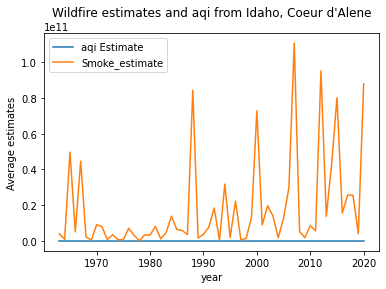

In [119]:
aqi_smoke_est_df.set_index('year')['aqi'].plot(legend=True, label='aqi Estimate')
aqi_smoke_est_df.set_index('year')['Smoke_estimate'].plot(legend=True, label='Smoke_estimate')
plt.title("Wildfire estimates and aqi from Idaho, Coeur d'Alene")
plt.xlabel('year')
plt.ylabel('Average estimates')
plt.savefig("Wildfire estimates and aqi from Idaho, Coeur d'Alene") 
plt.show()